In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model


import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_data_dir = r"/content/drive/MyDrive/Master/Semester III/Project/output/train"
valid_data_dir = r"/content/drive/MyDrive/Master/Semester III/Project/output/val"
test_data_dir = r"/content/drive/MyDrive/Master/Semester III/Project/output/test"

In [4]:
IMG_HEIGHT, IMG_WIDTH = (224, 224)

BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical")

valid_generator = train_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical")


test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    class_mode="categorical")

Found 9219 images belonging to 2 classes.
Found 2634 images belonging to 2 classes.
Found 1318 images belonging to 2 classes.


In [5]:
X, y = test_generator.next()
X.shape

(1, 224, 224, 3)

In [6]:
EPOCHS = 10
device = 'cuda:0' # use 'cpu' if a GPU is not available.

base_model = ResNet50(include_top=False, weights="imagenet")

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)

predictions = Dense(train_generator.num_classes, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
    

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["acc"])


history = model.fit(test_generator,
                    validation_data=valid_generator,
                    epochs=EPOCHS)

94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/10
1318/1318 [==============================] - 938s 708ms/step - loss: 0.5993 - acc: 0.8369 - val_loss: 0.3178 - val_acc: 0.8561
Epoch 2/10
1318/1318 [==============================] - 760s 577ms/step - loss: 0.2941 - acc: 0.8809 - val_loss: 1.0771 - val_acc: 0.8052
Epoch 3/10
1318/1318 [==============================] - 770s 584ms/step - loss: 0.2712 - acc: 0.8839 - val_loss: 0.7589 - val_acc: 0.8295
Epoch 4/10
1318/1318 [==============================] - 770s 585ms/step - loss: 0.2414 - acc: 0.8998 - val_loss: 0.3907 - val_acc: 0.8565
Epoch 5/10
1318/1318 [==============================] - 752s 571ms/step - loss: 0.2155 - acc: 0.9097 - val_loss: 0.5551 - val_acc: 0.8481
Epoch 6/10
1318/1318 [==============================] - 765s 581ms/step - loss: 0.1871 - acc: 0.9196 - val_loss: 0.5520 - val_acc: 0.8523
Epoch 7/10
1318/1318 [==============================] - 797s 605ms/step - loss: 0.1863 - acc: 0.9234 - val_

In [8]:
import json

with open('resnet_history.json', 'w') as file:
    json.dump(history.history, file)

In [16]:
torch.save(model, r'/content/drive/MyDrive/Master/Semester III/Project/resNET_pre_trained_model.pth')

INFO:tensorflow:Assets written to: ram://b70ea8ee-3001-4fc3-8389-9b03c4574f5a/assets


In [13]:
#plt.plot(history.history)
print(history.history)

{'loss': [0.5992957353591919, 0.2940612733364105, 0.2711934745311737, 0.24142055213451385, 0.21553508937358856, 0.1871105134487152, 0.1863468885421753, 0.14649301767349243, 0.14134538173675537, 0.12819761037826538], 'acc': [0.8368740677833557, 0.8808801174163818, 0.8839150071144104, 0.8998482823371887, 0.9097116589546204, 0.9195750951766968, 0.9233687520027161, 0.9400606751441956, 0.9415781497955322, 0.9484066963195801], 'val_loss': [0.3177589774131775, 1.0770670175552368, 0.7588887810707092, 0.3906955420970917, 0.5551175475120544, 0.5520157814025879, 0.7146321535110474, 0.7495647072792053, 0.6143271923065186, 0.7525123357772827], 'val_acc': [0.8561123609542847, 0.805239200592041, 0.8295368552207947, 0.8564920425415039, 0.8481397032737732, 0.8523158431053162, 0.8397874236106873, 0.8409263491630554, 0.8564920425415039, 0.8496583104133606]}


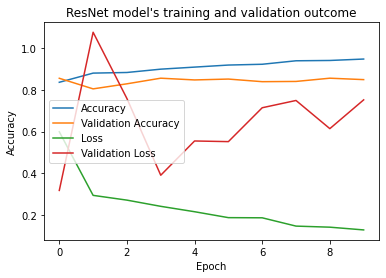

In [18]:
plt.plot(history.history["acc"])
plt.plot(history.history['val_acc'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("ResNet model's training and validation outcome")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy", "Validation Accuracy", "Loss", "Validation Loss"])
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.show()

In [10]:
model_loss, model_accuracy = model.evaluate(test_generator, batch_size = 50)
print("Accuracy: {:5.2f}%".format(100 * model_accuracy))
print("Loss: {:5.2f}%".format(100 * model_loss))

1318/1318 [==============================] - 310s 235ms/step - loss: 0.0822 - acc: 0.9651
Accuracy: 96.51%
Loss:  8.22%


In [17]:
model_loss, model_accuracy = model.evaluate(valid_generator, batch_size = 50)
print("Accuracy: {:5.2f}%".format(100 * model_accuracy))
print("Loss: {:5.2f}%".format(100 * model_loss))

83/83 [==============================] - 509s 6s/step - loss: 0.7829 - acc: 0.8493
Accuracy: 84.93%
Loss: 78.29%


In [20]:
model_loss, model_accuracy = model.evaluate(valid_generator, batch_size = 50)
print("Accuracy: {:5.2f}%".format(100 * model_accuracy))
print("Loss: {:5.2f}%".format(100 * model_loss))

83/83 [==============================] - 480s 6s/step - loss: 0.7364 - acc: 0.8462
Accuracy: 84.62%
Loss: 73.64%


In [19]:
model.eval()
results = model(test_generator)
print(results)

AttributeError: ignored

In [21]:
P = model.predict(test_generator)

In [30]:
print(P.shape)

correct_pred, num_examples = 0, 0
for i, (features, targets) in enumerate(test_generator):
  print(i, P[i], targets[i])         
  if(np.argmax(P[i]) == np.argmax(targets[i])):
      correct_pred = correct_pred + 1
  num_examples = features.shape[0]

    #targets = np.argmax( targets ,axis=1)
pre_accuracy = 100 * float(correct_pred/num_examples)        
print('Predict Accuracy: {}' .format(pre_accuracy))
    
    #correct_pred += (predicted_labels == targets).sum()
#p_acc =  correct_pred.float()/num_examples * 100

(1318, 2)
0 [0.6690527  0.33094722] [1. 0.]


IndexError: ignored

In [22]:
from sklearn.metrics import classification_report

print(classification_report(2, P, target_names=['0', '1']))

TypeError: ignored